# KNN Models

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import sys
sys.path.append('../lib')

import numpy as np
import pandas as pd

import torch
import pytorch_common.util as pu

import model as ml
import data.dataset as ds
import metric as mt

In [26]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [27]:
pu.set_device_name('gpu')
cpu = torch.device("cpu")

In [28]:
pu.get_device()

device(type='cuda', index=0)

In [29]:
torch.cuda.is_available()

True

In [30]:
torch.__version__

'1.11.0'

## Carga de dataset

1. importamos los archivos de peliculas y ratings preprocesados prebiamente en mongodb:

In [31]:
def features_fn(obs, device): return torch.tensor(obs[['user_seq', 'movie_seq']].values).to(device)
def target_fn(obs, device):   return torch.tensor(obs['user_movie_rating'].values).to(device)

In [32]:
dataset = ds.MovieLensTMDbJSONDataset(transform=features_fn, target_transform=target_fn, device=cpu)

In [33]:
user_predictor = ml.KNNUserBasedPredictor.from_data_frame(
    data          = dataset.data,
    user_seq_col  = 'user_seq',
    movie_seq_col = 'movie_seq',
    rating_col    = 'user_movie_rating',
    distance      = ml.CosineDistance()
)
# user_predictor.plot()

build ratting matrix:   0%|          | 0/199791 [00:00<?, ?it/s]

build distances matrix:   0%|          | 0/13280 [00:00<?, ?it/s]

In [34]:
item_predictor = ml.KNNItemBasedPredictor.from_data_frame(
    data          = dataset.data,
    user_seq_col  = 'user_seq',
    movie_seq_col = 'movie_seq',
    rating_col    = 'user_movie_rating',
    distance      = ml.CosineDistance()
)
# item_predictor.plot()

Build Ratting Matrix:   0%|          | 0/199791 [00:00<?, ?it/s]

Build Distances Matrix:   0%|          | 0/22081 [00:00<?, ?it/s]

In [35]:
validator = ml.Validator(
    n_samples  = 50, 
    batch_size = 50,
    metrics    = [
        mt.RMSEMetric(),
        mt.PrecisionMetric(),
        mt.RecallMetric(),
        mt.FBetaMetric(beta=1),
        mt.FBetaMetric(beta=0.5),
        mt.FBetaMetric(beta=1.5)
    ],
    predictors = [user_predictor, item_predictor]
)

In [36]:
summary = validator.validate(
    dataset,
    n_neighbors=3000
)

Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Predictor: KNNItemBasedPredictor

Range: (0.1373, 0.43)



<Figure size 1080x288 with 2 Axes>

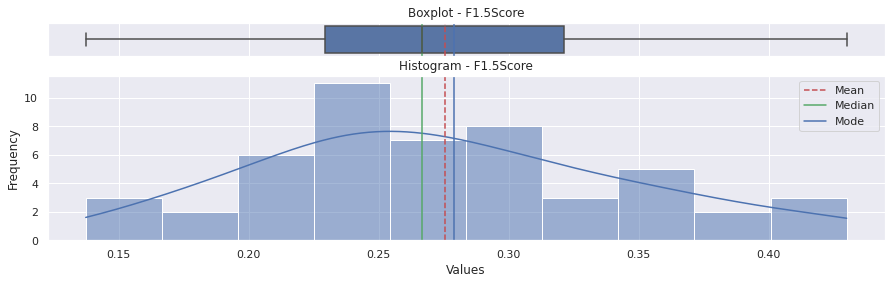


Metrics:



,F1.5Score
count,50.000000
mean,0.275470
std,0.072065
min,0.137300
25%,0.229375
50%,0.266700
75%,0.321125
max,0.430000


Predictor: KNNUserBasedPredictor

Range: (0.1167, 0.3284)



<Figure size 1080x288 with 2 Axes>

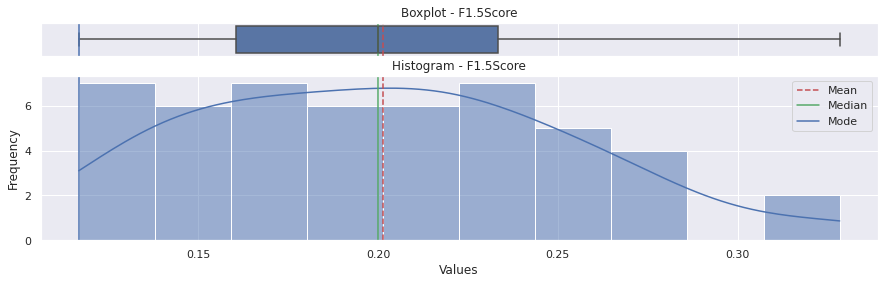


Metrics:



,F1.5Score
count,50.000000
mean,0.201442
std,0.052308
min,0.116700
25%,0.160500
50%,0.200050
75%,0.233400
max,0.328400


Predictor: KNNItemBasedPredictor

Range: (0.1384, 0.4412)



<Figure size 1080x288 with 2 Axes>

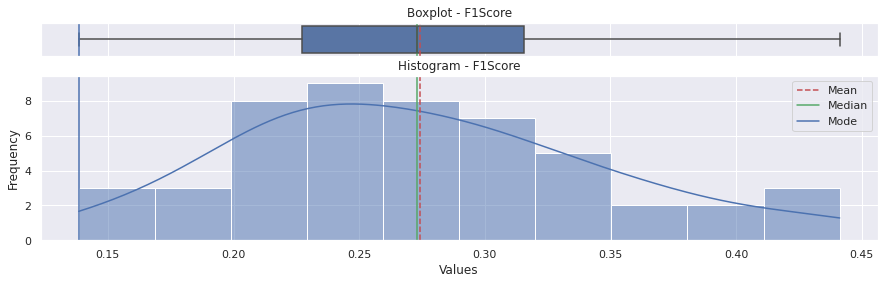


Metrics:



,F1Score
count,50.000000
mean,0.274182
std,0.072414
min,0.138400
25%,0.227125
50%,0.273200
75%,0.315550
max,0.441200


Predictor: KNNUserBasedPredictor

Range: (0.1022, 0.3418)



<Figure size 1080x288 with 2 Axes>

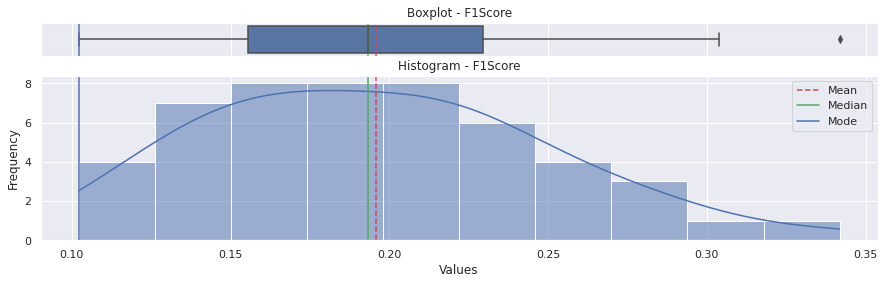


Metrics:



,F1Score
count,50.000000
mean,0.195882
std,0.053686
min,0.102200
25%,0.155450
50%,0.193300
75%,0.229650
max,0.341800


Predictor: KNNItemBasedPredictor

Range: (0.1429, 0.4455)



<Figure size 1080x288 with 2 Axes>

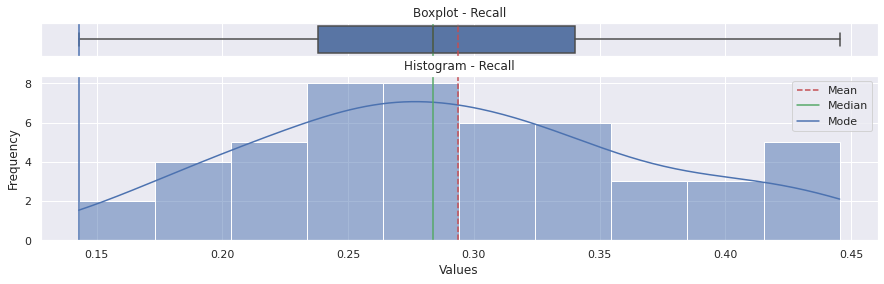


Metrics:



,Recall
count,50.000000
mean,0.293588
std,0.077548
min,0.142900
25%,0.238100
50%,0.283750
75%,0.340250
max,0.445500


Predictor: KNNUserBasedPredictor

Range: (0.134, 0.3873)



<Figure size 1080x288 with 2 Axes>

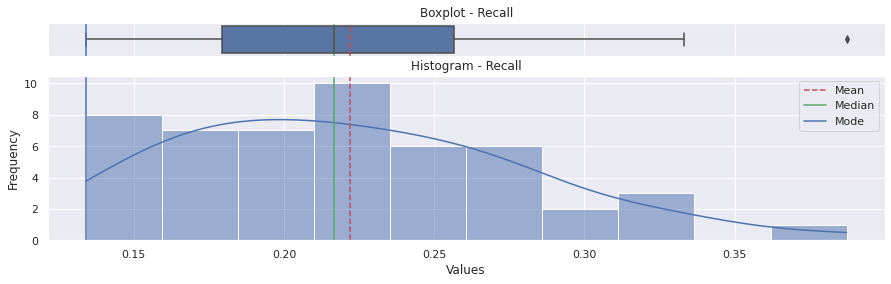


Metrics:



,Recall
count,50.000000
mean,0.221924
std,0.058124
min,0.134000
25%,0.179375
50%,0.216650
75%,0.256600
max,0.387300


Predictor: KNNItemBasedPredictor

Range: (0.1421, 0.4875)



<Figure size 1080x288 with 2 Axes>

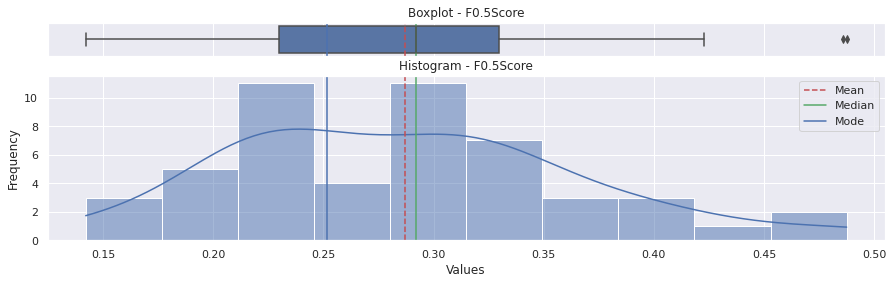


Metrics:



,F0.5Score
count,50.000000
mean,0.287196
std,0.079115
min,0.142100
25%,0.230000
50%,0.292100
75%,0.329625
max,0.487500


Predictor: KNNUserBasedPredictor

Range: (0.0865, 0.4015)



<Figure size 1080x288 with 2 Axes>

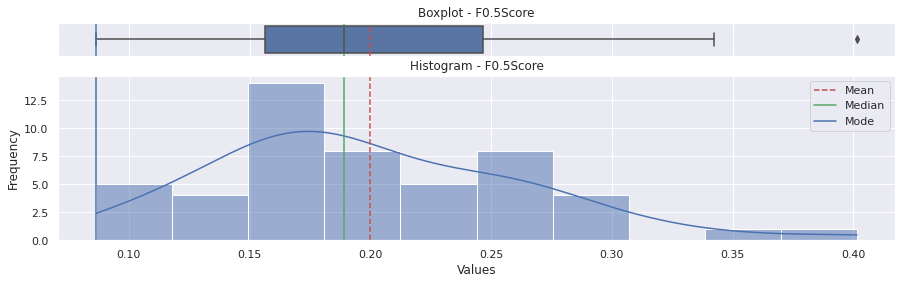


Metrics:



,F0.5Score
count,50.000000
mean,0.199732
std,0.065042
min,0.086500
25%,0.156425
50%,0.189250
75%,0.246725
max,0.401500


Predictor: KNNItemBasedPredictor

Range: (0.6748999953269958, 1.5094000101089478)



<Figure size 1080x288 with 2 Axes>

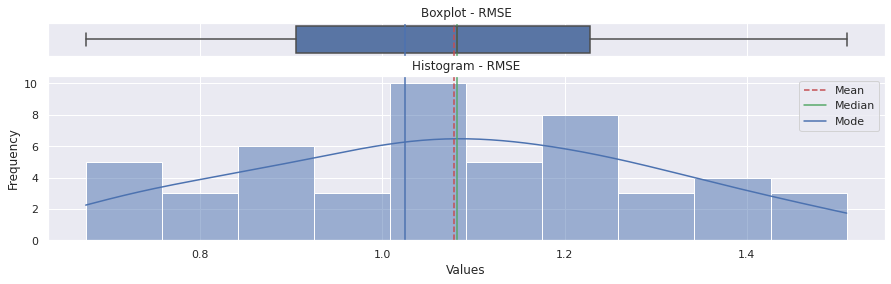


Metrics:



,RMSE
count,50.000000
mean,1.079198
std,0.222374
min,0.674900
25%,0.905675
50%,1.082200
75%,1.228300
max,1.509400


Predictor: KNNUserBasedPredictor

Range: (0.8065999746322632, 1.6239999532699585)



<Figure size 1080x288 with 2 Axes>

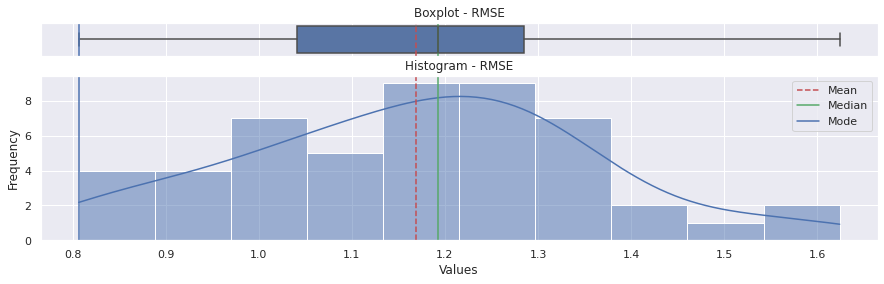


Metrics:



,RMSE
count,50.000000
mean,1.168784
std,0.188870
min,0.806600
25%,1.041250
50%,1.192850
75%,1.284800
max,1.624000


Predictor: KNNItemBasedPredictor

Range: (0.136, 0.5685)



<Figure size 1080x288 with 2 Axes>

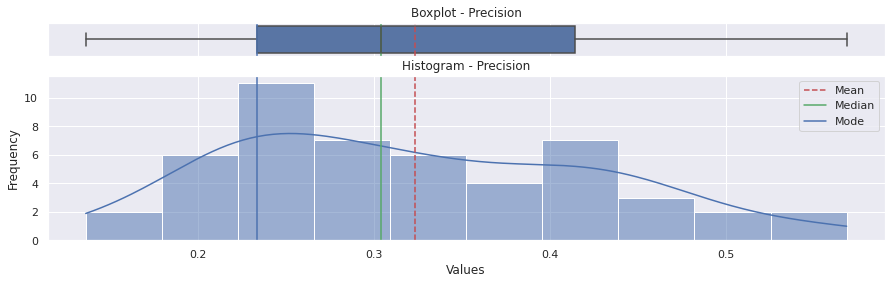


Metrics:



,Precision
count,50.000000
mean,0.323110
std,0.104876
min,0.136000
25%,0.233300
50%,0.303700
75%,0.413900
max,0.568500


Predictor: KNNUserBasedPredictor

Range: (0.0787, 0.51)



<Figure size 1080x288 with 2 Axes>

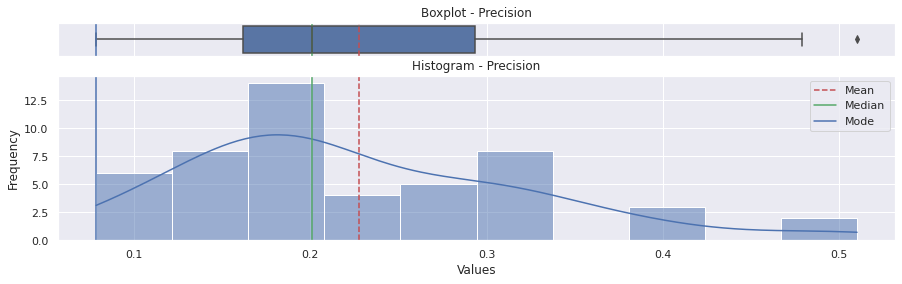


Metrics:



,Precision
count,50.000000
mean,0.227862
std,0.096956
min,0.078700
25%,0.162050
50%,0.201300
75%,0.293625
max,0.510000


In [37]:
summary.plot()

In [38]:
validator = ml.Validator(
    n_samples  = 10,
    batch_size = 1000,
    metrics    = [
        mt.MeanAveragePrecisionAtkMetric(user_index=0, k=5, binarizer=mt.between(4, 5))
    ],
    predictors = [user_predictor]
)

In [39]:
summary = validator.validate(
    dataset, 
    n_neighbors=5000
)

Processing:   0%|          | 0/10 [00:00<?, ?it/s]

Predictor: KNNUserBasedPredictor

Range: (0.3481000065803528, 0.5468999743461609)



<Figure size 1080x288 with 2 Axes>

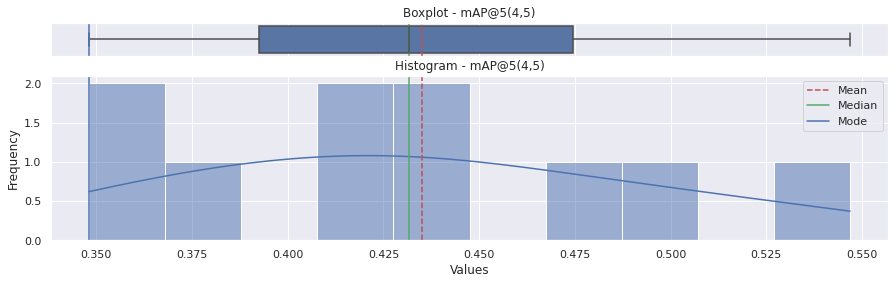


Metrics:



,"mAP@5(4,5)"
count,10.000000
mean,0.435090
std,0.062018
min,0.348100
25%,0.392550
50%,0.431700
75%,0.474550
max,0.546900


In [41]:
summary.plot()